In [1]:
!pip install pandas

    100% |████████████████████████████████| 8.9MB 3.0MB/s eta 0:00:01
mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os 
import pandas as pd

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("test").enableHiveSupport().getOrCreate()
databases = spark.sql("show databases").collect()
print(databases)
        

[Row(databaseName='default')]


In [3]:
from pyspark.sql.types import *
schema = StructType([
    StructField("id", StringType(), True),
    StructField("txid", StringType(), True),
    StructField("vin_txid", StringType(), True),
    StructField("vin_vout_n", IntegerType(), True),
    StructField("blockhash", StringType(), True),
    StructField("blocktime", StringType(), True)])

df_raw_in = spark.read.load("gs://btc-analysis-tw/data/tx-in-all.csv", format="csv", delimiter="\t", header=False, schema=schema)
# df_in.take(1)

In [4]:
from pyspark.sql.types import *
schema = StructType([
    StructField("id", StringType(), True),
    StructField("txid", StringType(), True),
    StructField("vout_txid", StringType(), True),
    StructField("vout_n", IntegerType(), True),
    StructField("address", StringType(), True),
    StructField("value", FloatType(), True),
    StructField("blockhash", StringType(), True),
    StructField("blocktime", StringType(), True),
    StructField("vout_type", StringType(), True),])

df_raw_out = spark.read.load("gs://btc-analysis-tw/data/tx-out-all.csv", format="csv", delimiter="\t", header=False, schema=schema)
# df_in.take(1)

In [5]:
df_raw_in.createOrReplaceTempView("tx_in")
df_vin_txid_num_ins = spark.sql("select txid, num_ins from (select txid,count(vin_txid) as num_ins from tx_in group by txid) tmp")
df_vin_txid_num_ins.take(5)

[Row(txid='00bffb72450e16b711a5c9ddebbcd85264fff5c7826fc3848a10d8c0631f98fa', num_ins=1),
 Row(txid='013320d2368d7541a07f16a5d95b23ade2e7cd0413d29741a673e1725227bdea', num_ins=10),
 Row(txid='01feb3d4568e5353a4422aa825d61b131ae9aba840d78e9555680203e3f334e8', num_ins=1),
 Row(txid='02f987ac3de2fef46f567ed3fc9112d3305ed683f03fab4cbde072292e2ebd25', num_ins=1),
 Row(txid='032ccb6aa242a549b0bcb76cbae6bb12fc3fb342dd581da8621b5adf75cdb0bb', num_ins=48)]

In [6]:
df_raw_out.createOrReplaceTempView("tx_out")
df_vout_txid_num_outs = spark.sql("select tx_in.txid,count(tx_in.vin_txid) as num_outs from tx_in join tx_out on tx_in.vin_txid = tx_out.vout_txid and tx_in.vin_vout_n = tx_out.vout_n group by tx_in.txid")
df_vout_txid_num_outs.take(5)

[Row(txid='0d0cadf79862567ebebfe551ad89eabd05c8325776c6be195c19c716df846202', num_outs=14),
 Row(txid='7d513d499d7c6ba8f3aabf3f2f7da53fc071b2ca0d91ab5d2b7a0bd557cef0f7', num_outs=1),
 Row(txid='5cd7a42dd85a723f690c93e8535fbb3c38075f57b8b96bef6ffcd3971f758caa', num_outs=29),
 Row(txid='8bb1bb7058fb51cfa94865c07ca505fc72e59cc65de5f4145efa8f0ee5e583bf', num_outs=2),
 Row(txid='ca9d0149b50f37e1f929f9a806b863768931dfb218569b18cf214c8650357a32', num_outs=4)]

In [7]:
df_vin_txid_num_ins.createOrReplaceTempView("vin_txid_num_ins")
df_vout_txid_num_outs.createOrReplaceTempView("vout_txid_num_outs")

df_total_in_value = spark.sql("""
        select tx_in.txid,sum(tx_out.value) as input_value,count(tx_in.vin_txid) as input_numbers from tx_in 
        join tx_out on tx_in.vin_txid = tx_out.vout_txid and tx_in.vin_vout_n = tx_out.vout_n 
        join vin_txid_num_ins on vin_txid_num_ins.txid = tx_in.txid 
        join vout_txid_num_outs on vout_txid_num_outs.txid = tx_in.txid 
        where vin_txid_num_ins.num_ins = vout_txid_num_outs.num_outs group by tx_in.txid""")
df_total_in_value.take(5)

[Row(txid='25b80aec1a6ece70095068f109b1c7f83d52454302a8b9d4a48ee567dd1f199e', input_value=102.61614227294922, input_numbers=1),
 Row(txid='3227e7914fe65984df353a7e14cd94bce909b8578418f8213d951b36fe3f04ac', input_value=0.018427599221467972, input_numbers=1),
 Row(txid='7d9e46a650c59e908e0188f4225b46d4519bf8ad80b4e2eadc7f18f63c5c9fe0', input_value=0.0026785999070852995, input_numbers=1),
 Row(txid='8ad98eddae32400c449c8daea91f7e3ef40d6ba29556818889e0f7b9c6debd6d', input_value=0.015773700550198555, input_numbers=1),
 Row(txid='c809f355c00af361fd1f8e4e4aa7dced7387b45e7f1a545ebfbaa9b4897272fe', input_value=0.0005466199945658445, input_numbers=1)]

In [8]:
df_total_in_value.createOrReplaceTempView("total_in_value")

df_total_out_value = spark.sql("""
        select tx_out.txid,sum(tx_out.value) as output_value, count(tx_out.txid) as output_numbers from tx_out 
        where tx_out.txid in (select distinct txid from total_in_value) group by tx_out.txid""")
df_total_out_value.take(5)

[Row(txid='0024c4636e0147f08e8e6e1075320b0644a23c354078b3e23cab675bf87724c6', output_value=1.2286601569503546, output_numbers=2),
 Row(txid='003bed188456a125efd04907f8e03552c50673f8deeba19cd7c1e26c75620d73', output_value=0.02084300946444273, output_numbers=2),
 Row(txid='0096b10759f548cded4922a17be3ced4c60a3cdeefa5fd13b05b9dc1c6ef3e81', output_value=0.0051015198696404696, output_numbers=3),
 Row(txid='00bffb72450e16b711a5c9ddebbcd85264fff5c7826fc3848a10d8c0631f98fa', output_value=0.0317195993848145, output_numbers=2),
 Row(txid='00f72a29316b4f08bb3a0eaee26da0616f1a6b025404783bb1100ae485b39036', output_value=11.184597005136311, output_numbers=24)]

In [9]:
txid_values = df_total_in_value.join(df_raw_in, df_total_in_value.txid == df_raw_in.txid).join(df_total_out_value, df_total_in_value.txid == df_total_out_value.txid)
txid_values.take(5)

[Row(txid='0024c4636e0147f08e8e6e1075320b0644a23c354078b3e23cab675bf87724c6', input_value=1.228688359260559, input_numbers=1, id='0', txid='0024c4636e0147f08e8e6e1075320b0644a23c354078b3e23cab675bf87724c6', vin_txid='ef9881b0e2c62462955dfef54ccea64d675d375c018e759f975109e9ff8d747b', vin_vout_n=1, blockhash='0000000000000000001190dc15f616f61494e38ef2f1f7f1b6bf0581b73243d2', blocktime='1539634150', txid='0024c4636e0147f08e8e6e1075320b0644a23c354078b3e23cab675bf87724c6', output_value=1.2286601569503546, output_numbers=2),
 Row(txid='003bed188456a125efd04907f8e03552c50673f8deeba19cd7c1e26c75620d73', input_value=0.020911069586873055, input_numbers=1, id='0', txid='003bed188456a125efd04907f8e03552c50673f8deeba19cd7c1e26c75620d73', vin_txid='0282ad4903cd1377a70933fccd4dbef6218b153c985b3e04b4aed8ba20ffdd15', vin_vout_n=1, blockhash='0000000000000000002504e3c3614ba453a073ed326ea92e466fe5683e184f3f', blocktime='1539665747', txid='003bed188456a125efd04907f8e03552c50673f8deeba19cd7c1e26c75620d73',

In [10]:
from datetime import datetime

txid_fees = txid_values.rdd.map(lambda tx: {"txid": tx.txid, "fee": tx.input_value - tx.output_value, "blocktime": datetime.utcfromtimestamp(int(tx.blocktime)).strftime('%Y%m%d%H%M')}).collect()
txid_fees[0:5]


[{'txid': '0024c4636e0147f08e8e6e1075320b0644a23c354078b3e23cab675bf87724c6',
  'fee': 2.820231020450592e-05,
  'blocktime': '201810152009'},
 {'txid': '003bed188456a125efd04907f8e03552c50673f8deeba19cd7c1e26c75620d73',
  'fee': 6.806012243032455e-05,
  'blocktime': '201810160455'},
 {'txid': '0096b10759f548cded4922a17be3ced4c60a3cdeefa5fd13b05b9dc1c6ef3e81',
  'fee': 2.465001307427883e-05,
  'blocktime': '201810160455'},
 {'txid': '00bffb72450e16b711a5c9ddebbcd85264fff5c7826fc3848a10d8c0631f98fa',
  'fee': 2.0790379494428635e-05,
  'blocktime': '201810151104'},
 {'txid': '00f72a29316b4f08bb3a0eaee26da0616f1a6b025404783bb1100ae485b39036',
  'fee': 9.96692106127739e-05,
  'blocktime': '201810160804'}]

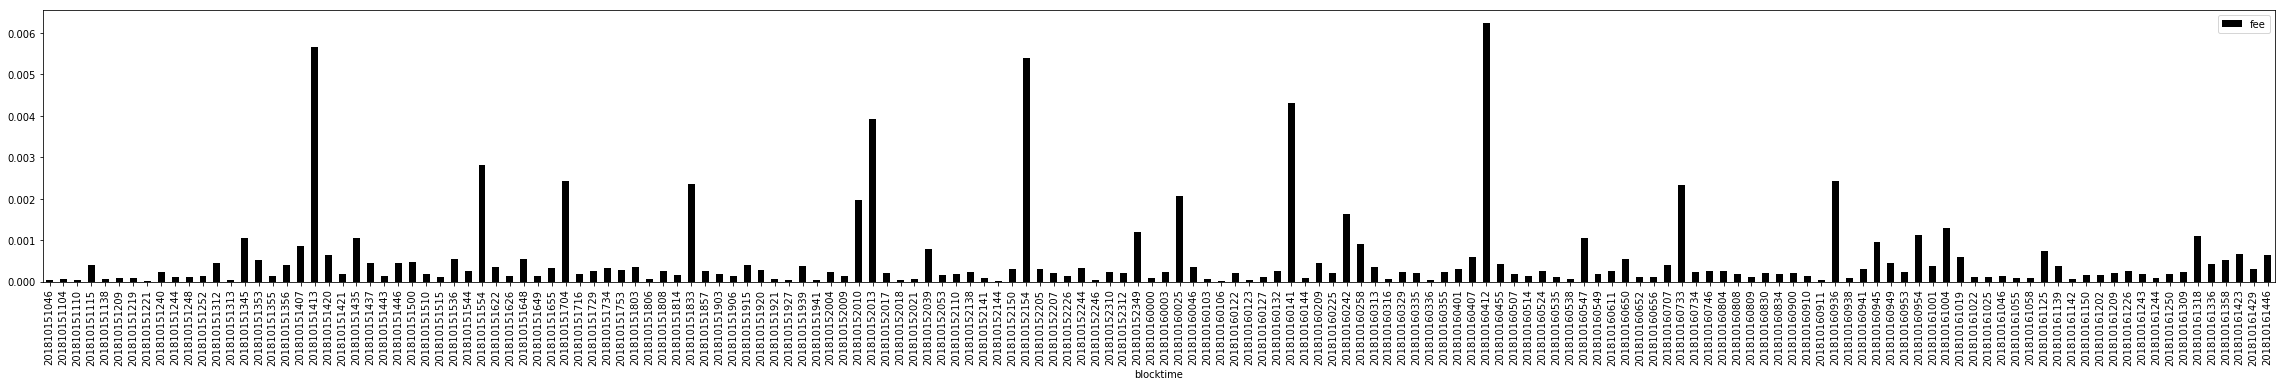

In [11]:
import matplotlib as plt

pd_fees = pd.DataFrame(txid_fees)
tx_fee_mean = pd_fees.groupby(['blocktime'], as_index=False).mean()
tx_fee_mean.plot(x='blocktime', y='fee', kind= 'bar', color='black', figsize=(40, 5))


In [12]:
txids = df_raw_in.rdd.map(lambda r: {'blocktime': datetime.utcfromtimestamp(int(r.blocktime)).strftime('%Y%m%d%H%M')}).collect()
txids[0:5]

[{'blocktime': '201810151110'},
 {'blocktime': '201810151110'},
 {'blocktime': '201810151345'},
 {'blocktime': '201810151345'},
 {'blocktime': '201810151345'}]

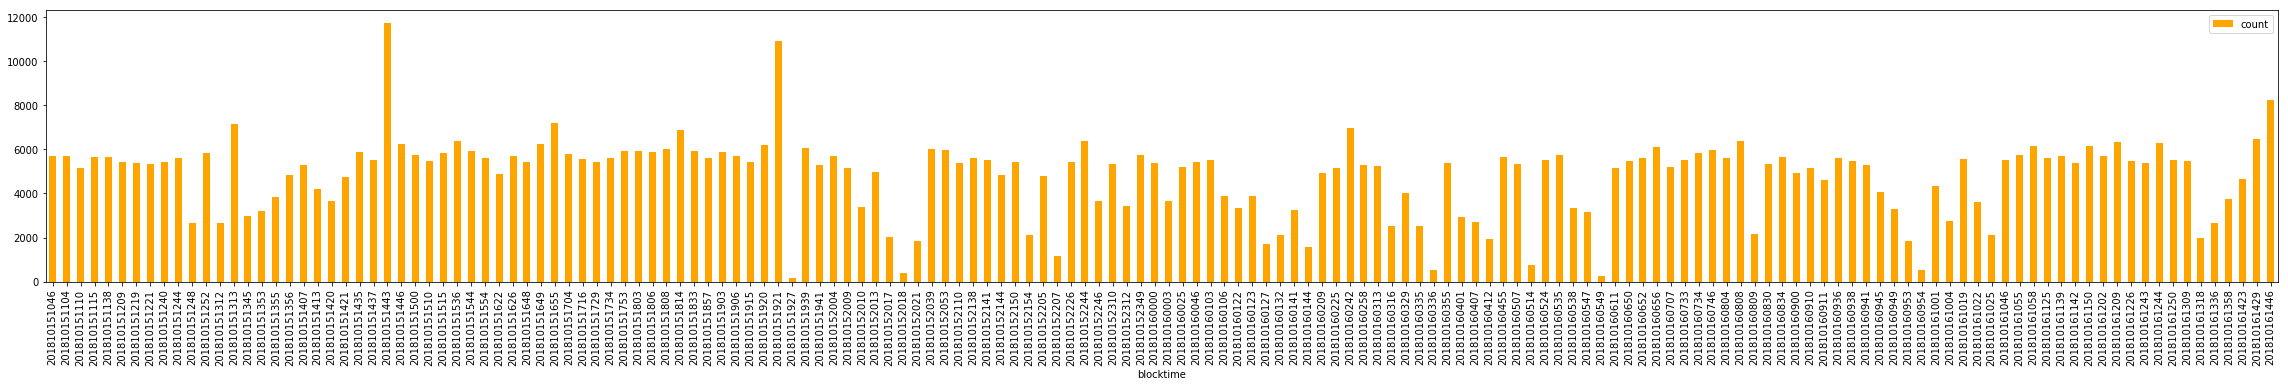

In [13]:
import numpy as np

pd_txs = pd.DataFrame(txids)
tx_size = pd_txs.groupby(['blocktime'], as_index=False).size().reset_index(name='count')
tx_size.plot(x='blocktime', y='count', kind='bar', color='orange', figsize=(40, 5))


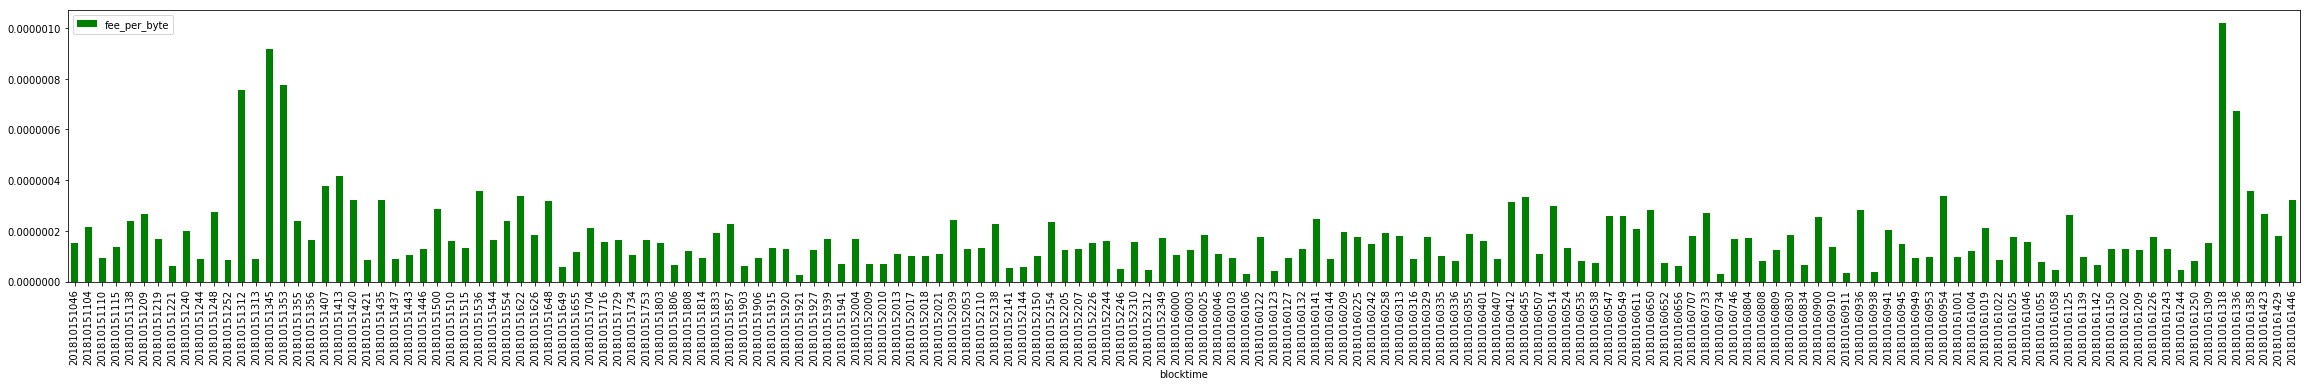

In [14]:
tx_fee_per_byte = txid_values.rdd.map(lambda tx: {"txid": tx.txid, "fee_per_byte": (tx.input_value - tx.output_value) / float((tx.input_numbers * 180) + (tx.output_numbers * 34) + 10), "blocktime": datetime.utcfromtimestamp(int(tx.blocktime)).strftime('%Y%m%d%H%M')}).collect()
pd_fee_per_byte = pd.DataFrame(tx_fee_per_byte)
tx_fee_per_byte_mean = pd_fee_per_byte.groupby(['blocktime'], as_index=False).mean()
tx_fee_per_byte_mean.plot(x='blocktime', y='fee_per_byte', kind='bar', color='green', figsize=(40, 5))


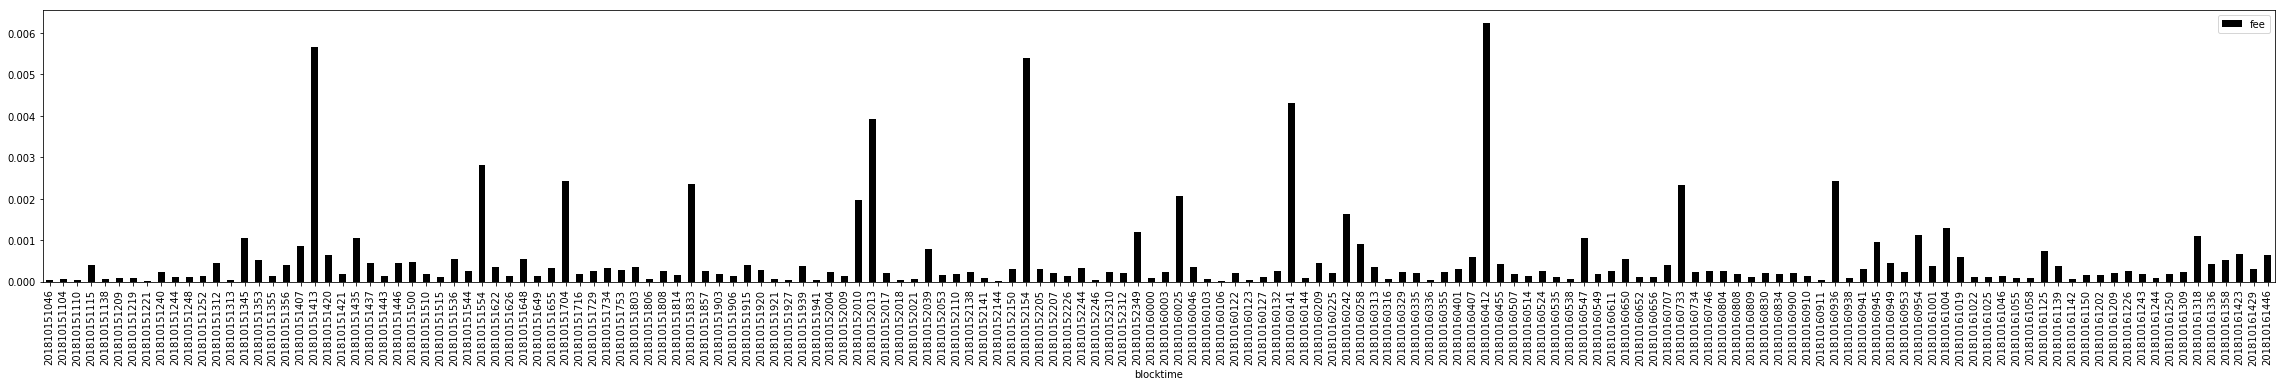

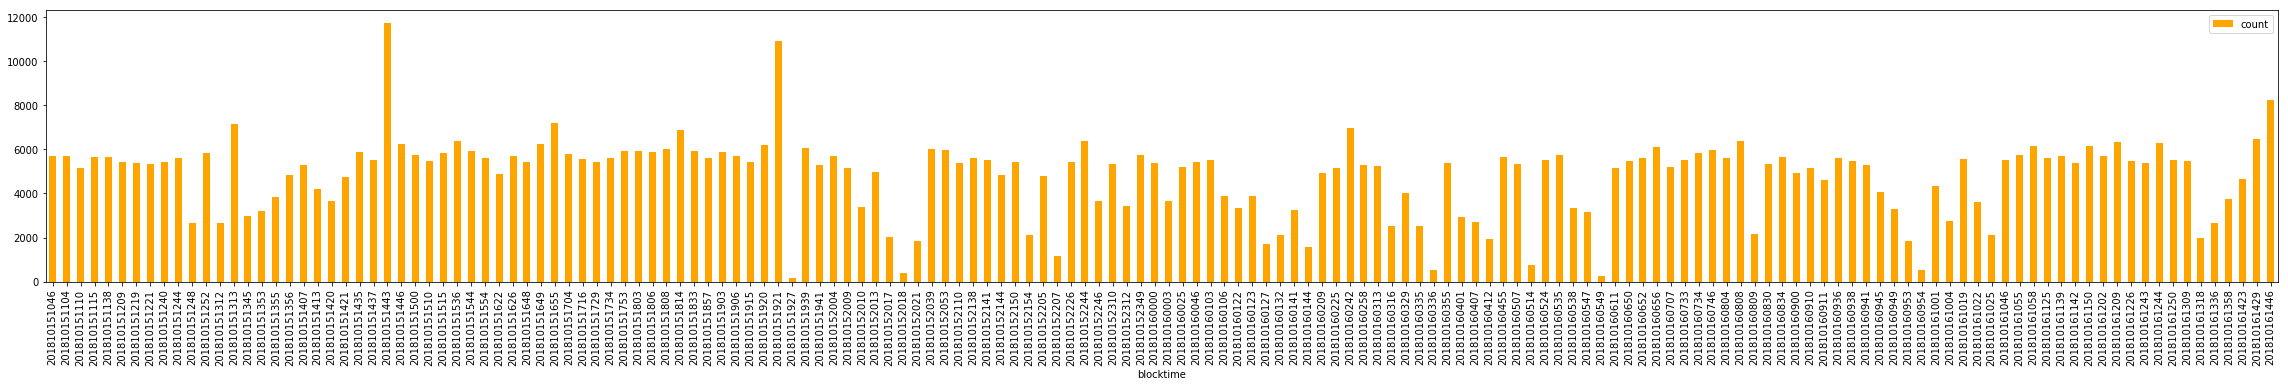

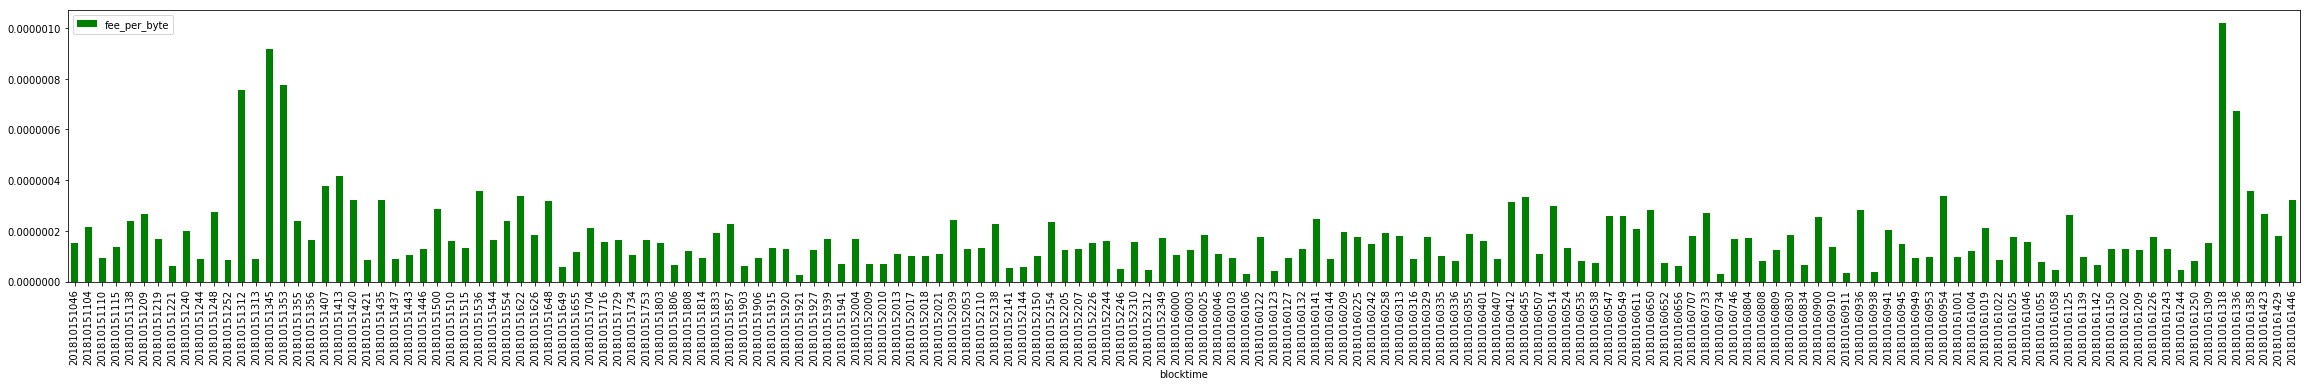

In [15]:
pd_tx_size = pd.DataFrame(tx_size)
pd_tx_fee_mean = pd.DataFrame(tx_fee_mean)
pd_fee_per_byte = pd.DataFrame(tx_fee_per_byte_mean)
pd_all = pd_tx_size.join(pd_tx_fee_mean.set_index('blocktime'), on='blocktime').join(pd_fee_per_byte.set_index('blocktime'), on='blocktime')

pd_all.plot(x='blocktime', y='fee', color='black', kind='bar', figsize=(40, 5))
pd_all.plot(x='blocktime', y='count', color='orange', kind='bar', figsize=(40, 5))
pd_all.plot(x='blocktime', y='fee_per_byte', color='green', kind='bar', figsize=(40, 5))
